##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [0]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 1.x

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


In [0]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

--2020-04-25 00:23:32--  https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  15.8MB/s    in 0.8s    

2020-04-25 00:23:33 (15.8 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load Input Images and Poses

(16,)
(17,)
1
(16,)
(17,)
2
(16,)
(17,)
3
(16,)
(17,)
4
(16,)
(17,)
5
(16,)
(17,)
6
(16,)
(17,)
7
(16,)
(17,)
8
(16,)
(17,)
9
(16,)
(17,)
10
(16,)
(17,)
11
(16,)
(17,)
12
(16,)
(17,)
13
(16,)
(17,)
14
(16,)
(17,)
15
(16,)
(17,)
16
(16,)
(17,)
17
(16,)
(17,)
18
(16,)
(17,)
19
(16,)
(17,)
20
(20, 4, 4)
(20, 150, 150, 3) (20, 4, 4) 73.30025007410362


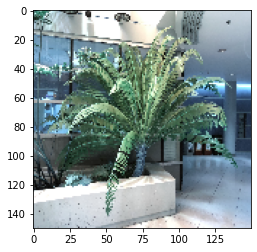

In [0]:
#data = np.load('tiny_nerf_data.npz')
#print(data['images'].shape)
#from matplotlib import image
#images_dir = dir('/content/drive/My Drive/Test_tiny_nerf/images')
#image_path='/content/drive/My Drive/Test_tiny_nerf/images/IMG_4045.JPG'
'''import glob
from tensorflow.python.keras.preprocessing.image import load_img
import torch 
import torch.tensor as tensor
#import numpy as np
folders = glob.glob('/content/drive/My Drive/Test_tiny_nerf/images/*')
imagenames_list = []
for image_path in folders:


#for filename in os.listdir(image_path):
#for image_path in path.glob("/content/drive/My Drive/Test_tiny_nerf/images/"):
  x =  np.array(load_img(image_path, target_size=(100, 100,3)))
  #x=tensor.numpy(x)
  imagenames_list.append(x)
#images=[]
#for img in images_dir:
#img_t =image.imread(img)
  

#images=np.array(imagenames_list)
#print(images.shape)
#images = data['images']
'''
import numpy as np
import cv2
minSize=150
IMG_DIR = '/content/drive/My Drive/Test_tiny_nerf/images'
images=[]
for img in os.listdir(IMG_DIR):
        img_array = cv2.imread(os.path.join(IMG_DIR,img), cv2.IMREAD_COLOR)
        img_array= cv2.resize(img_array, dsize=(minSize, minSize), interpolation=cv2.INTER_CUBIC)
        images.append(img_array)

images=np.array(images)
#images=img_array
poses=np.load('/content/drive/My Drive/Test_tiny_nerf/poses_bounds.npy')
#This has to be split into two arrays ..
#The first should be 4*4 -pos
#The last element seperate-focal length
#print(poses)
#poses = data['poses']
#focal = data['focal']
f=[]
p=[]
i=1
for a in poses:
  f.append(a[16])
  p.append(a[0:16])
  print(a[0:16].shape)
  print(a.shape)
  print(i)
  i=i+1
focal=np.mean(f)
poses=np.array(p)
poses=np.reshape(poses,[20,4,4])
poses=np.double(poses)
print(poses.shape)
#focal=np.load('/content/drive/My Drive/Test_tiny_nerf/simplices.npy')
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

#print(data["images"].shape,data["poses"].shape)
#print(data["poses"].dtype)
#testimg, testpose = images[101], poses[101]
testimg, testpose = images[10], poses[10]
#images = images[:100,...,:3]

#poses = poses[:100]

plt.imshow(testimg)
plt.show()

# Optimize NeRF

In [0]:


def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

<dtype: 'float64'>
<dtype: 'float32'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0.023327178955078125 secs per iter
<dtype: 'float64'>
<dtype: 'float32'>


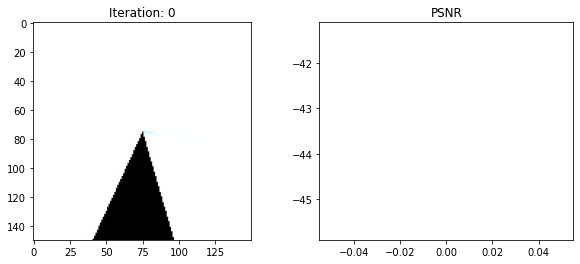

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
25 0.3429788875579834 secs per iter
<dtype: 'float

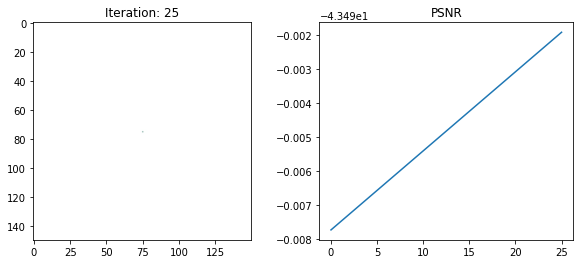

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
50 0.3416287612915039 secs per iter
<dtype: 'float

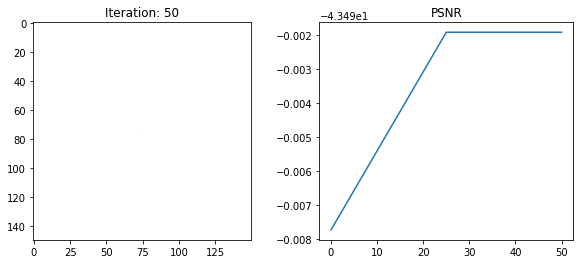

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
75 0.3426243782043457 secs per iter
<dtype: 'float

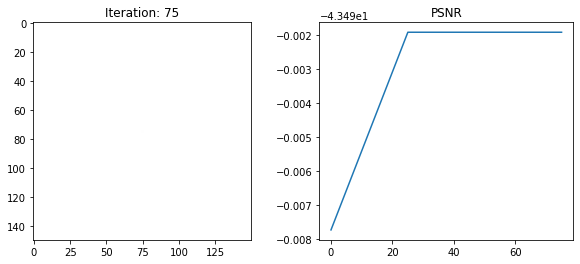

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
100 0.3479733848571777 secs per iter
<dtype: 'floa

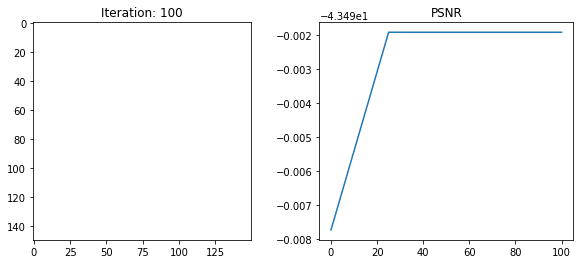

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
125 0.34206007957458495 secs per iter
<dtype: 'flo

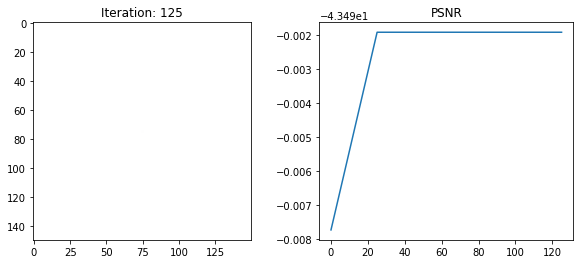

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
150 0.34545166015625 secs per iter
<dtype: 'float6

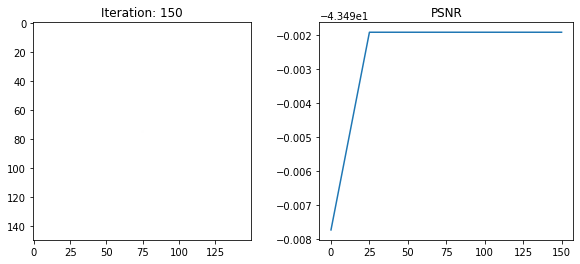

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
175 0.34165613174438475 secs per iter
<dtype: 'flo

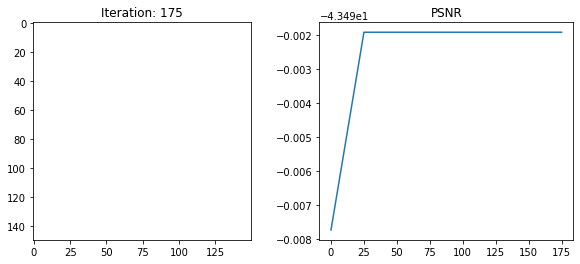

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
200 0.34226049423217775 secs per iter
<dtype: 'flo

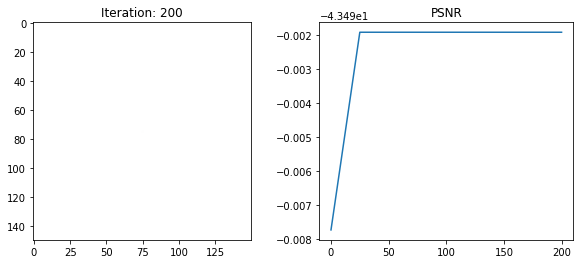

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
225 0.3404441928863525 secs per iter
<dtype: 'floa

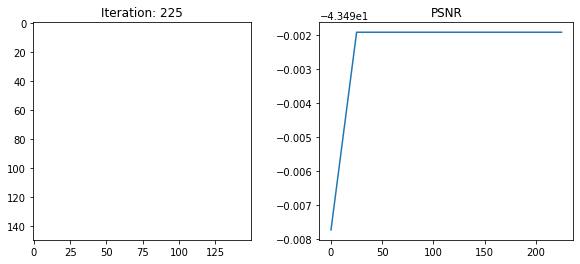

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
250 0.34242417335510256 secs per iter
<dtype: 'flo

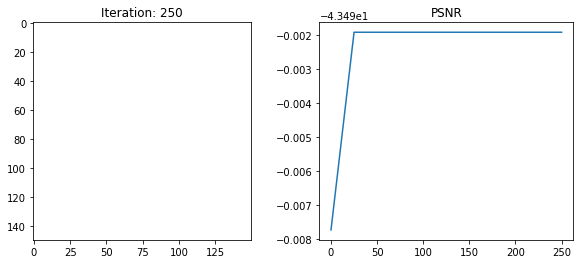

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
275 0.34171630859375 secs per iter
<dtype: 'float6

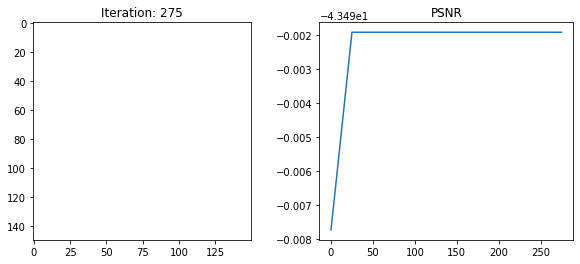

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
300 0.34799346923828123 secs per iter
<dtype: 'flo

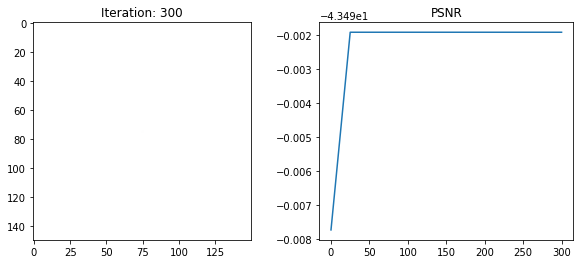

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
325 0.34164623260498045 secs per iter
<dtype: 'flo

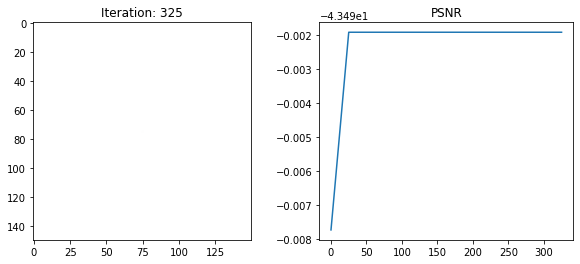

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
350 0.3426787281036377 secs per iter
<dtype: 'floa

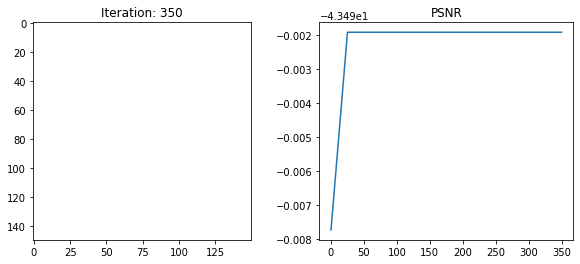

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
375 0.34274359703063967 secs per iter
<dtype: 'flo

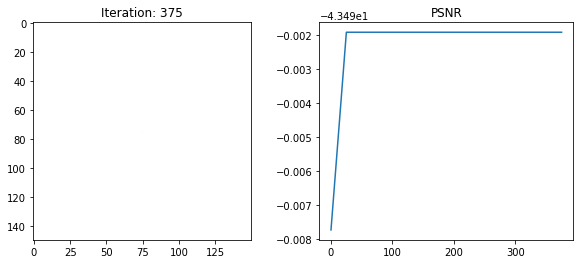

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
400 0.34285332679748537 secs per iter
<dtype: 'flo

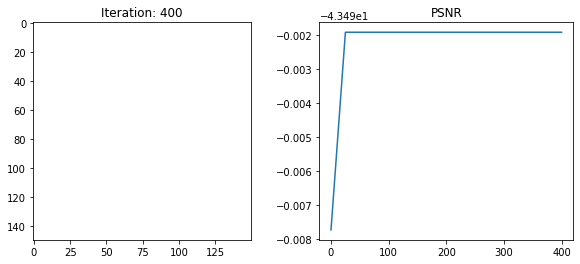

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
425 0.34185428619384767 secs per iter
<dtype: 'flo

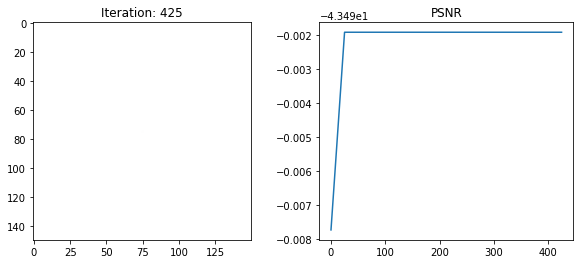

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
450 0.34116644859313966 secs per iter
<dtype: 'flo

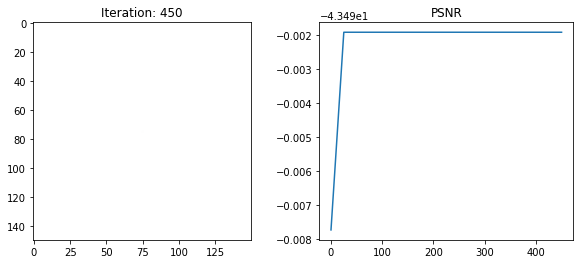

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
475 0.34400028228759766 secs per iter
<dtype: 'flo

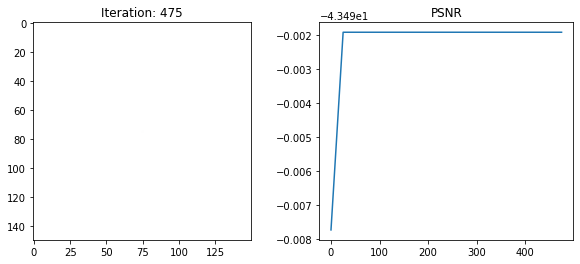

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
500 0.3499566459655762 secs per iter
<dtype: 'floa

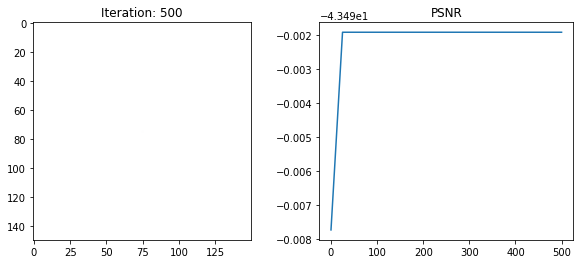

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
525 0.3419760799407959 secs per iter
<dtype: 'floa

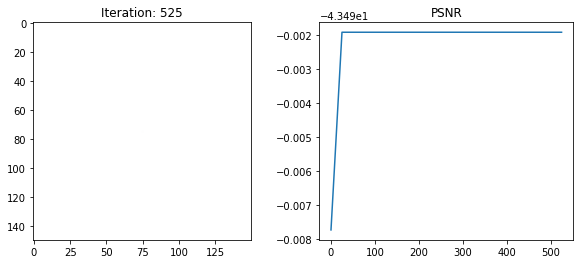

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
550 0.34323927879333493 secs per iter
<dtype: 'flo

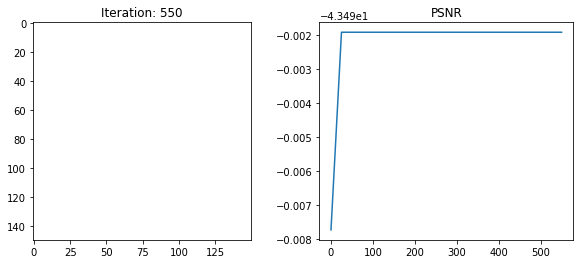

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
575 0.3422131156921387 secs per iter
<dtype: 'floa

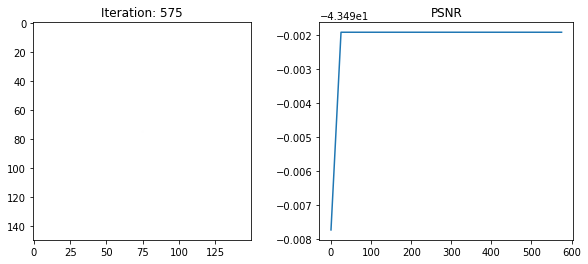

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
600 0.34197343826293947 secs per iter
<dtype: 'flo

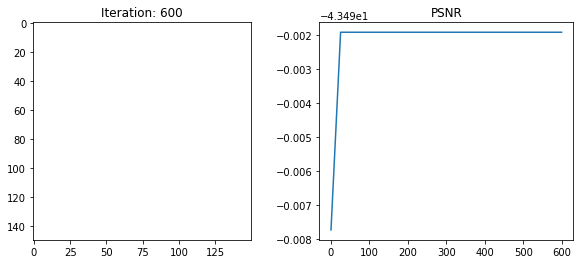

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
625 0.344607458114624 secs per iter
<dtype: 'float

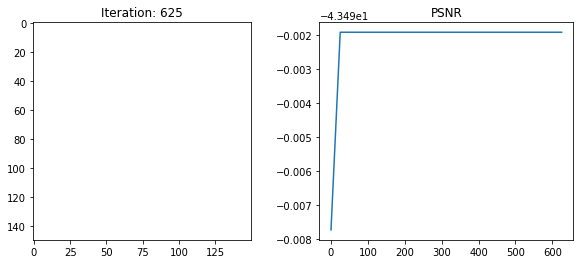

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
650 0.3432831573486328 secs per iter
<dtype: 'floa

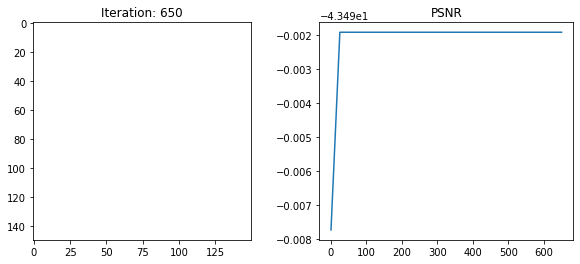

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
675 0.3435826873779297 secs per iter
<dtype: 'floa

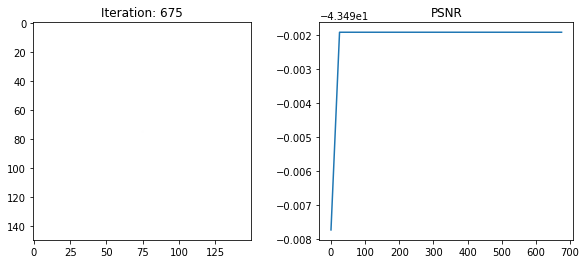

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
700 0.3474100399017334 secs per iter
<dtype: 'floa

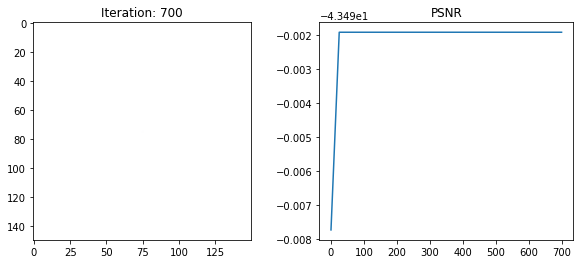

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
725 0.3416385078430176 secs per iter
<dtype: 'floa

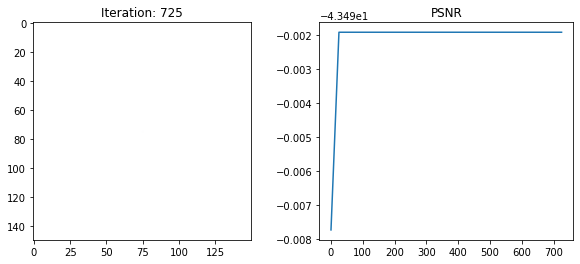

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
750 0.3422761154174805 secs per iter
<dtype: 'floa

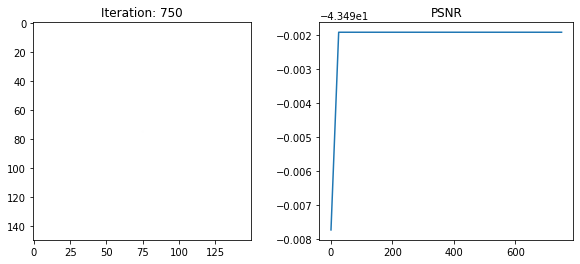

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
775 0.34062127113342283 secs per iter
<dtype: 'flo

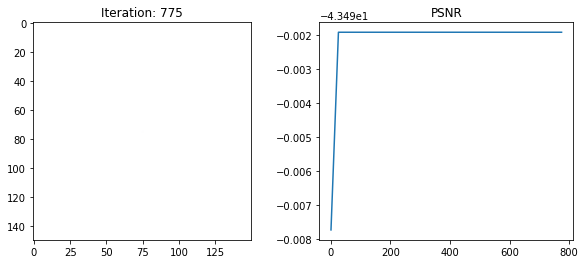

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
800 0.340911808013916 secs per iter
<dtype: 'float

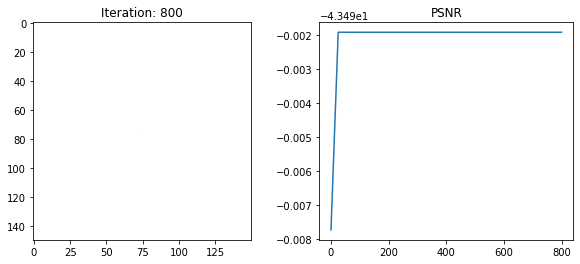

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
825 0.34278242111206053 secs per iter
<dtype: 'flo

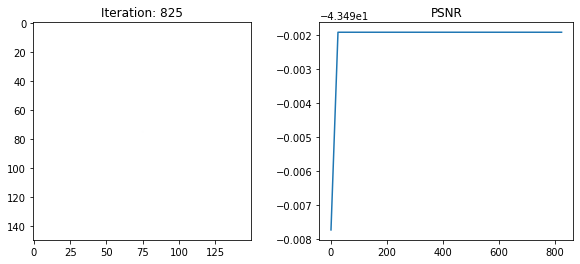

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
850 0.3424832534790039 secs per iter
<dtype: 'floa

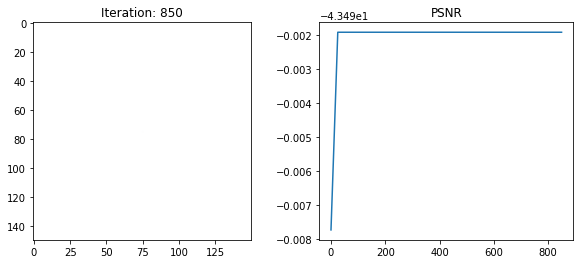

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
875 0.3416721248626709 secs per iter
<dtype: 'floa

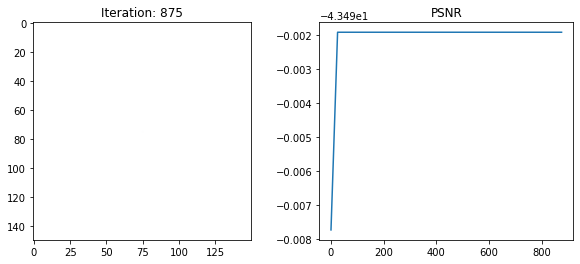

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
900 0.34597227096557615 secs per iter
<dtype: 'flo

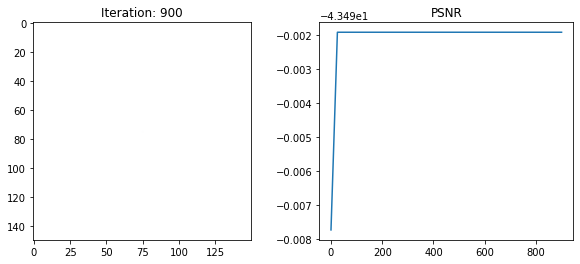

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
925 0.34169026374816897 secs per iter
<dtype: 'flo

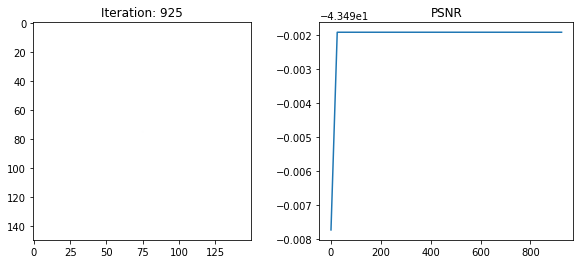

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
950 0.3403694534301758 secs per iter
<dtype: 'floa

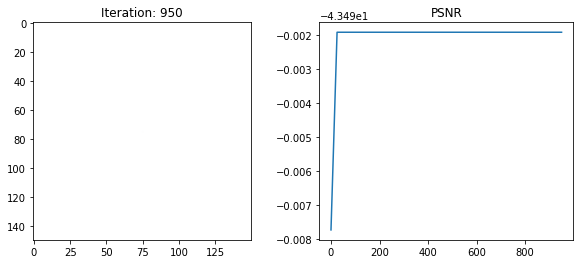

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
975 0.34152517318725584 secs per iter
<dtype: 'flo

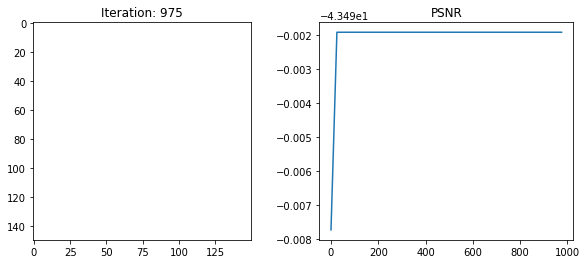

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>
1000 0.34159138679504397 secs per iter
<dtype: 'fl

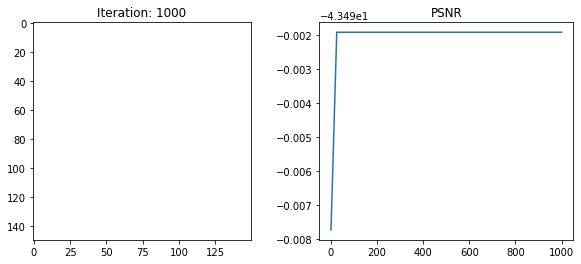

Done


In [0]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_samples = 20
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    print(rays_o.dtype)
    print(rays_d.dtype)
    rays_o=np.double(rays_o)
    rays_d=np.double(rays_d)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        print(rays_o.dtype)
        print(rays_d.dtype)
        rays_o=np.double(rays_o)
        rays_d=np.double(rays_d)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

# Interactive Visualization

In [0]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [0]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)